<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_localhost(): 
    hostname = !hostname
    return hostname[0] == 'skynet'

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
if not is_localhost(): 
    !pip install mne

     |████████████████████████████████| 6.9 MB 5.4 MB/s 


# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [4]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if not is_localhost():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

dataset
├── suj_10_bl_1.txt
├── suj_10_bl_2.txt
├── suj_12_bl_1.txt
├── suj_12_bl_2.txt
├── suj_13_bl_1.txt
├── suj_13_bl_2.txt
├── suj_8_bl_1.txt
├── suj_8_bl_2.txt
├── suj_9_bl_1.txt
└── suj_9_bl_2.txt

0 directories, 10 files


# 3. Importa libreria del proyecto

In [6]:
if not is_localhost():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

Pull...

From https://github.com/magistery-tps/dm-cyt-tp
 * branch            main       -> FETCH_HEAD
Already up to date.


In [7]:
sys.path.append('./src' if is_localhost() else '/content/dm-cyt-tp/src')

# 4. Importa paquetes externos

In [9]:
import matplotlib.pylab as plt 

import numpy as np
import pandas as pd

from scipy.signal import find_peaks
from sklearn.cluster import KMeans

from plot import *
from eeg  import get_info_eeg_and_montage, channels

from read_eeg  import load_egg, load_eeg_dataset, to_data_frame

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo de la señal orginal es de 256 Hz, luego fue filtrada y resampleada a 128 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [10]:
eegs = load_eeg_dataset('./dataset/*')

In [11]:
eegs[0].to_dict()

{'data': array([[  8.8053  ,   2.8521  ,   8.4599  , ...,  -7.5154  ,   5.6913  ,
         -18.52    ],
        [ 12.527   ,   4.2622  ,  10.628   , ..., -10.427   ,   5.6633  ,
         -21.176   ],
        [ 17.019   ,   5.8066  ,   9.0612  , ...,  -9.7515  ,   8.0545  ,
         -22.238   ],
        ...,
        [ -9.8746  ,  -0.13757 ,   4.4853  , ...,   3.5603  ,  -5.5463  ,
           1.5543  ],
        [ -4.883   ,   1.2051  ,   2.5195  , ...,   5.6999  ,  -1.6198  ,
          -1.4655  ],
        [  1.134   ,   2.622   ,   0.058498, ...,   8.3902  ,   3.0574  ,
          -5.5949  ]]),
 'nchannels': 30,
 'nsamples': 7681,
 'resting_state': '1',
 'sfrequency': 128,
 'subject': '8'}

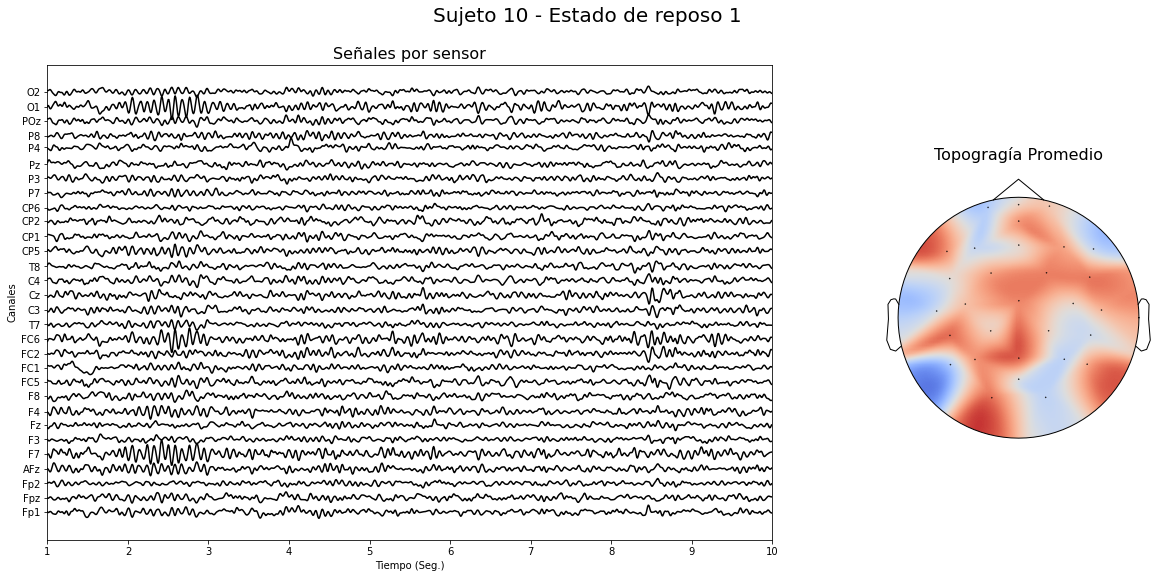

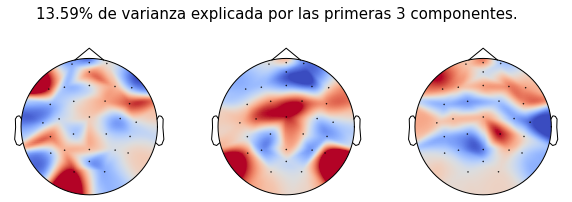

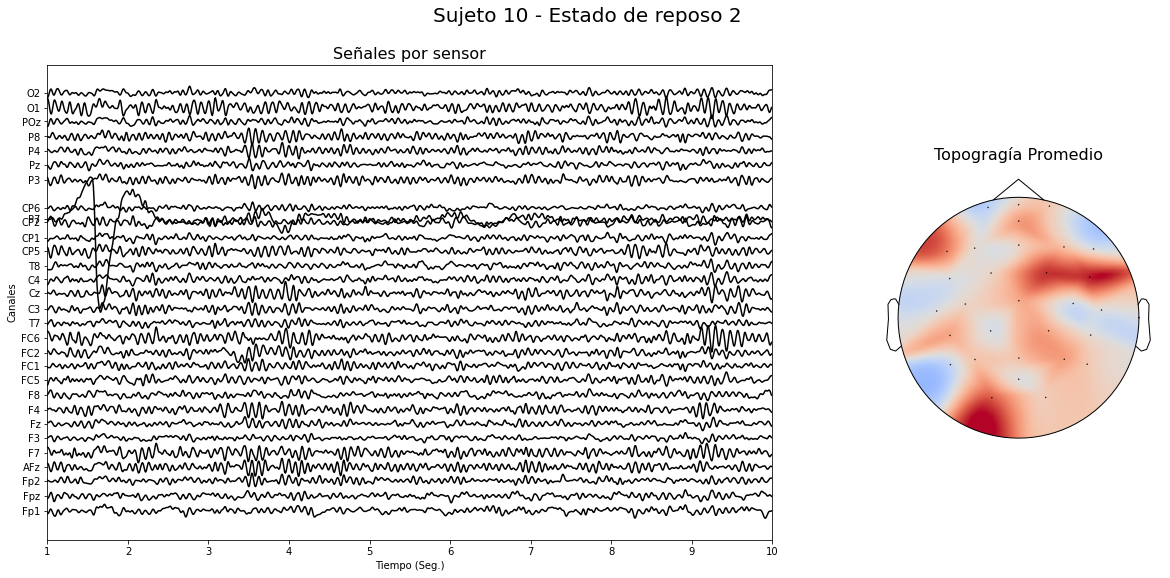

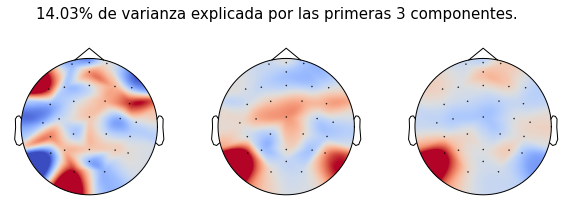

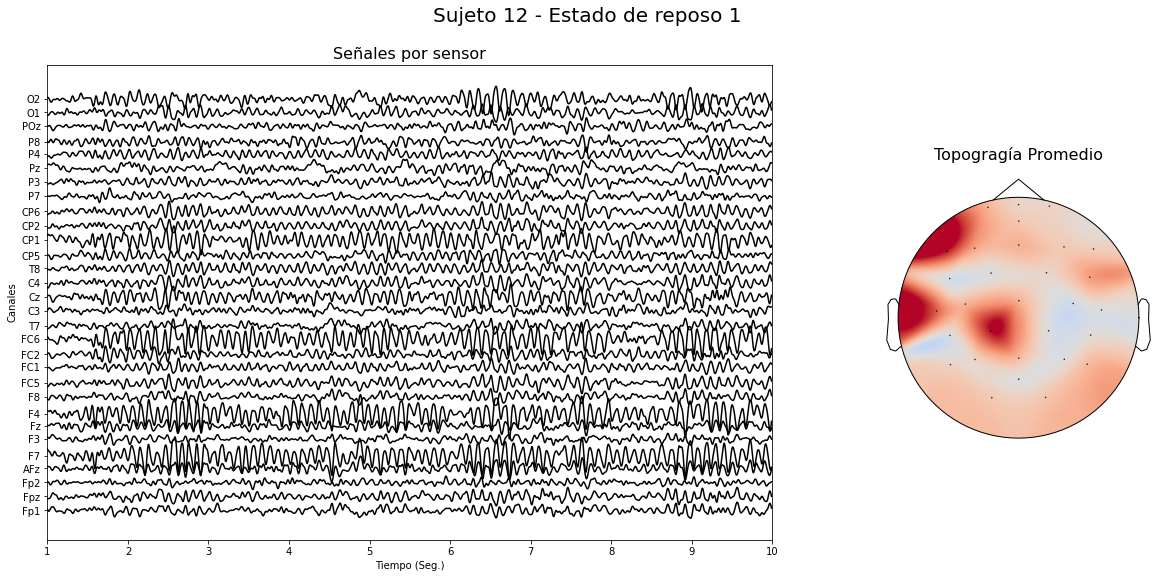

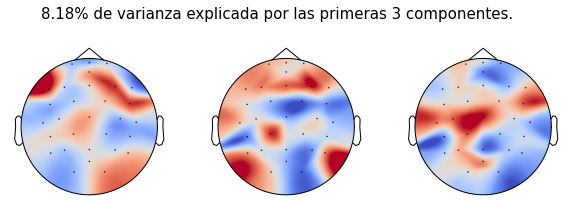

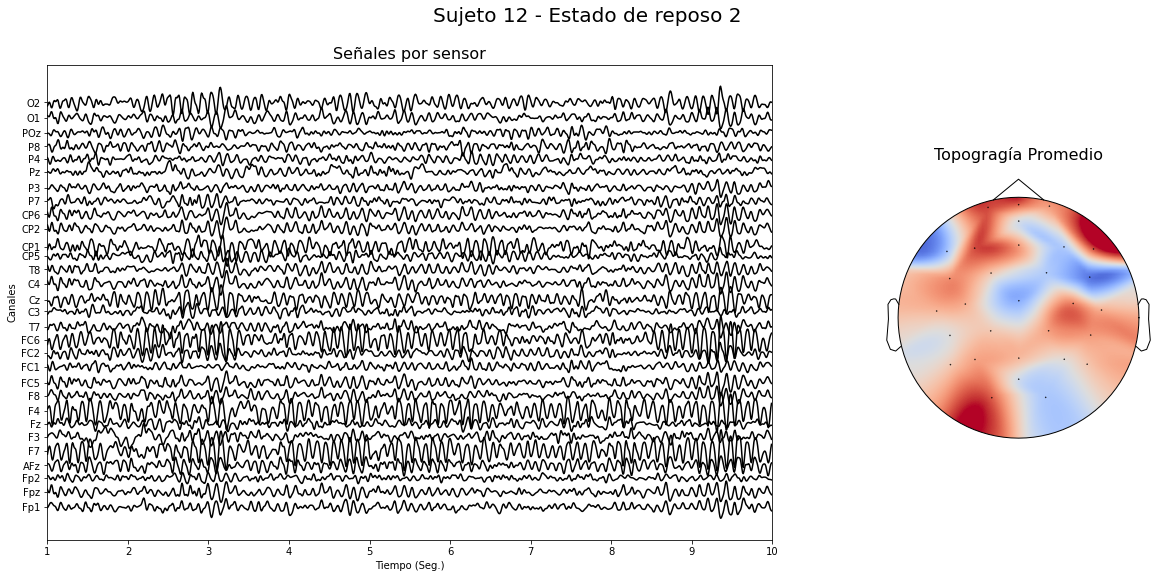

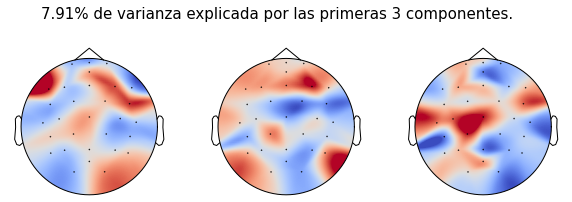

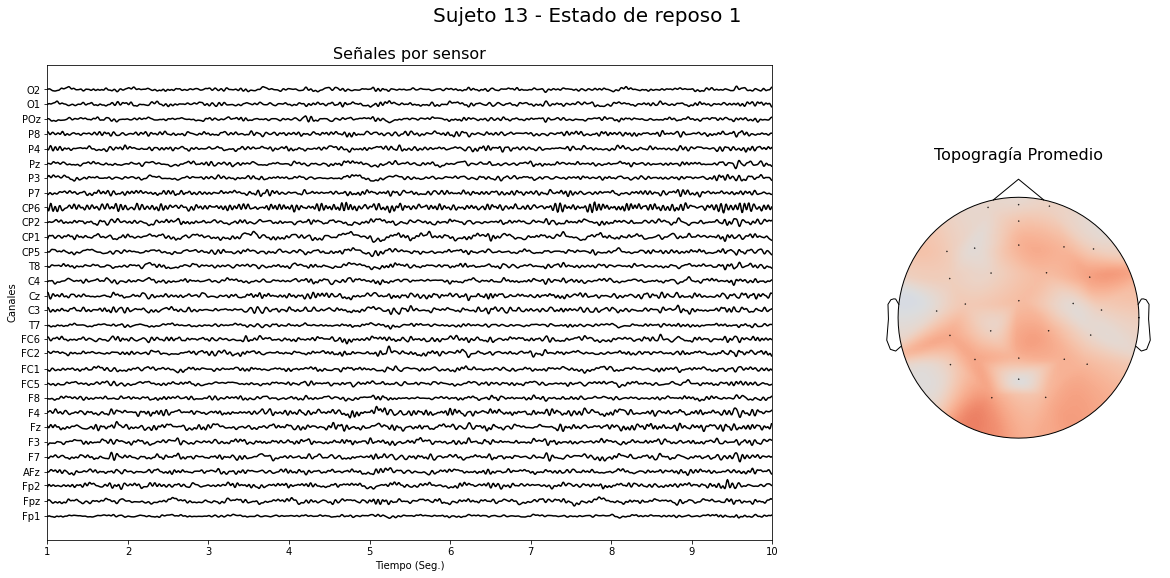

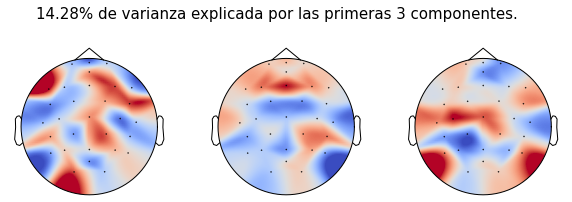

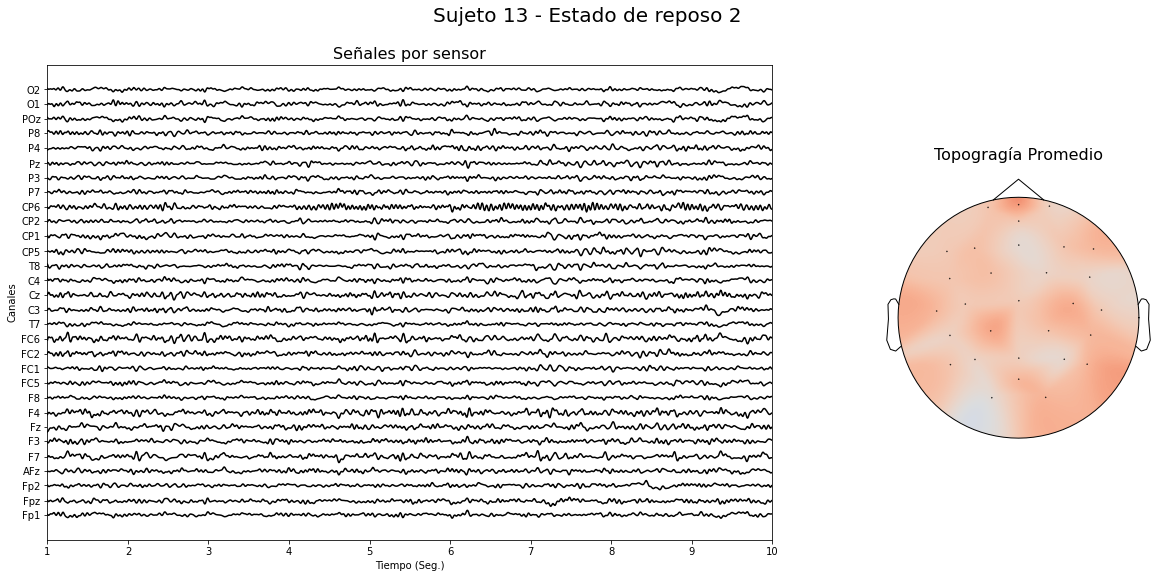

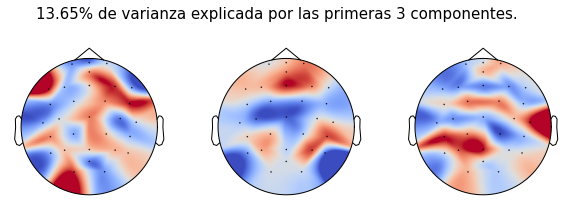

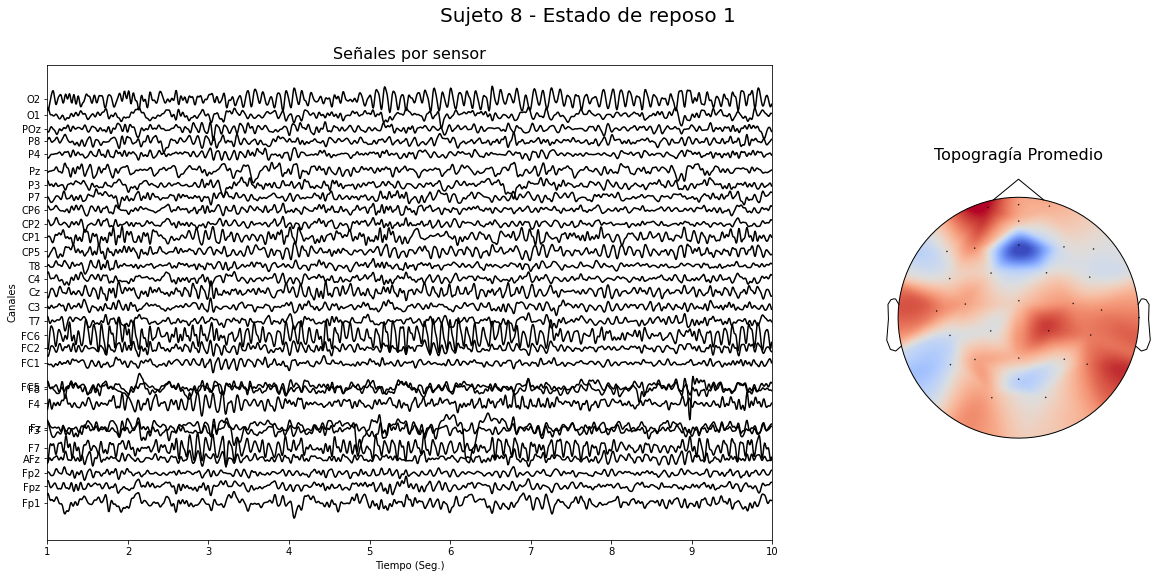

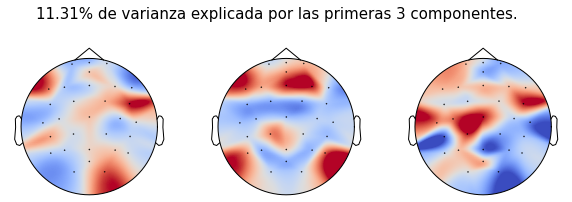

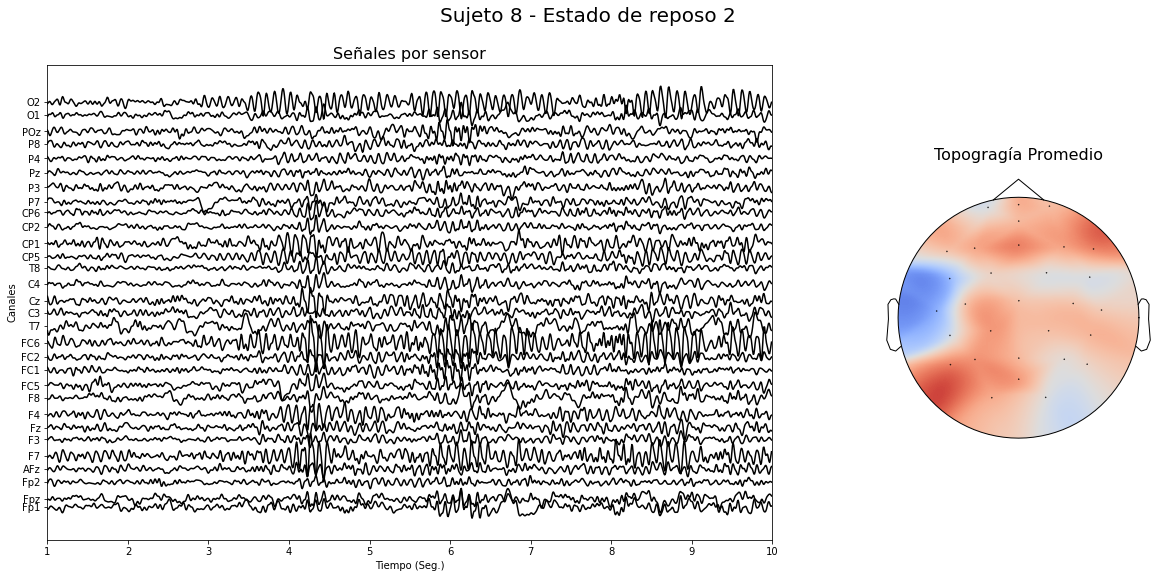

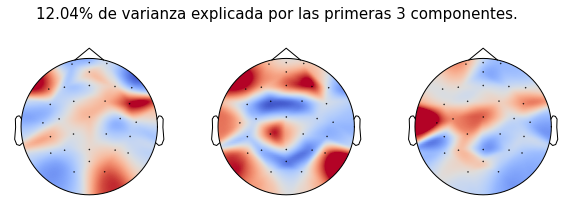

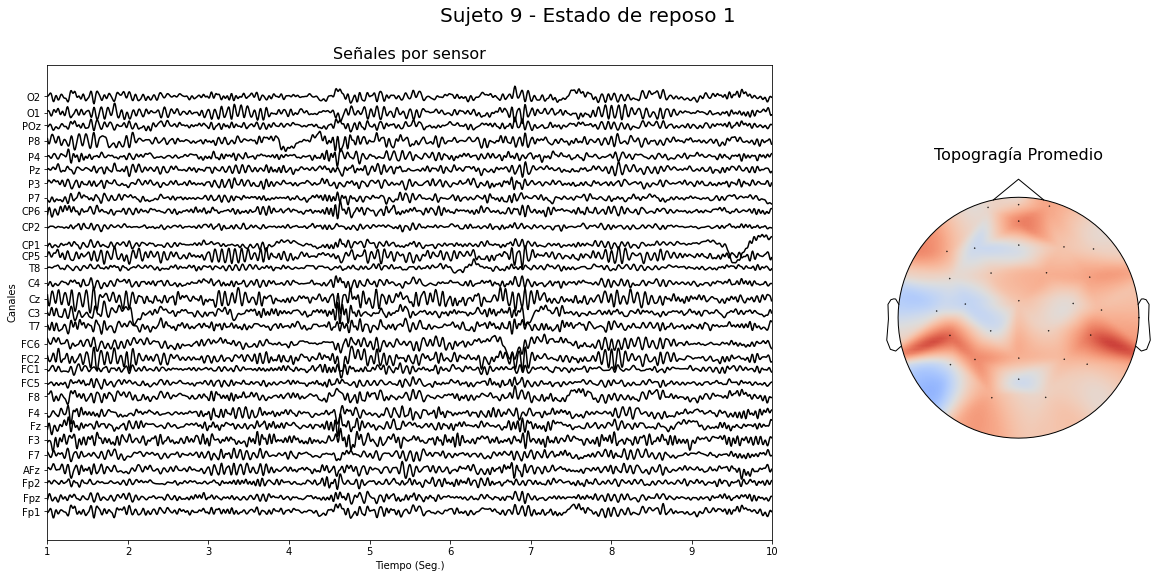

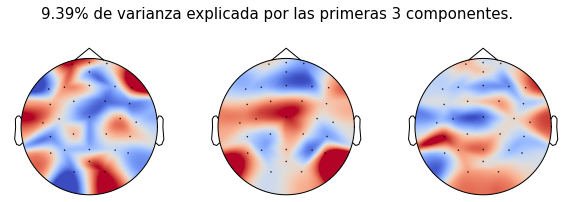

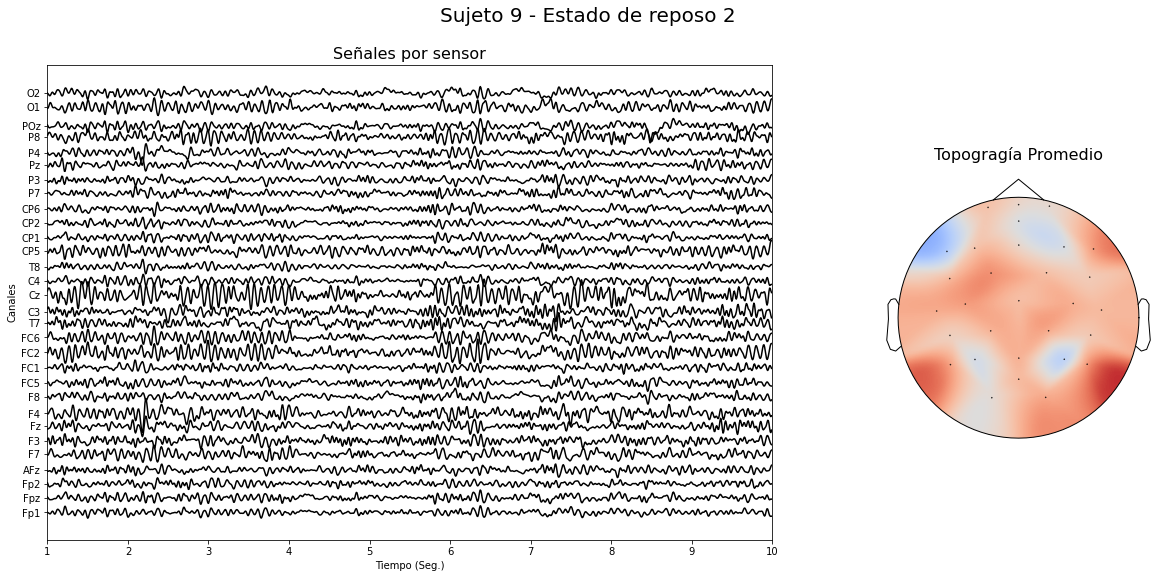

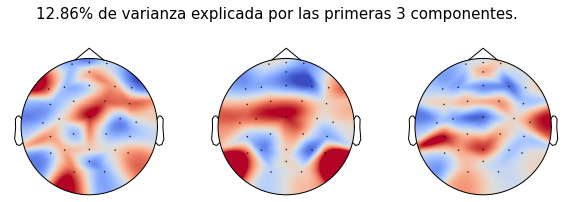

In [12]:
info_eeg, mont1020_30 = get_info_eeg_and_montage()
datos_orig            = np.empty((0,32))  #30 canales + 2 metadata individuo y tipo de reposo
promedios_totales     = np.empty((0,30))
inicio                = 1 #calcula los promedios entre 1 y 4
fin                   = 4

for eeg in sorted(eegs, key=lambda it: it.subject + it.resting_state):
    participante = np.repeat(int(eeg.subject), eeg.nsamples).reshape(eeg.nsamples, 1)
    tipo       = np.repeat(int(eeg.resting_state), eeg.nsamples).reshape(eeg.nsamples, 1)    
    
    metadata   = np.concatenate((participante,tipo),axis=1)
    datos_orig = np.concatenate((datos_orig,np.concatenate((eeg.data, metadata),axis=1)),axis=0)

    promedios         = eeg.data[inicio*eeg.sfrequency:fin*eeg.sfrequency, :].mean(axis=0)
    promedios_totales = np.concatenate((promedios_totales, promedios.reshape(1,30)), axis=0) 

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1.2]})
    fig.suptitle(f'Sujeto {eeg.subject} - Estado de reposo {eeg.resting_state}', size=20, y=1.05)

    plot_egg_on_axis(axes[0], eeg, mont1020_30)
    plot_eeg_topology_on_axis(
        axes[1],
        promedios, 
        info_eeg,
        -0.54932109,  # Estos son los valores máximo y minimo de todos los promedios.
        0.34050091
    )
 
    plot_eeg_pca(info_eeg, eeg.dataT())

In [13]:
print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.34050090885416645
-0.5493210911458329


In [14]:
datos_orig.shape

(76810, 32)

Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
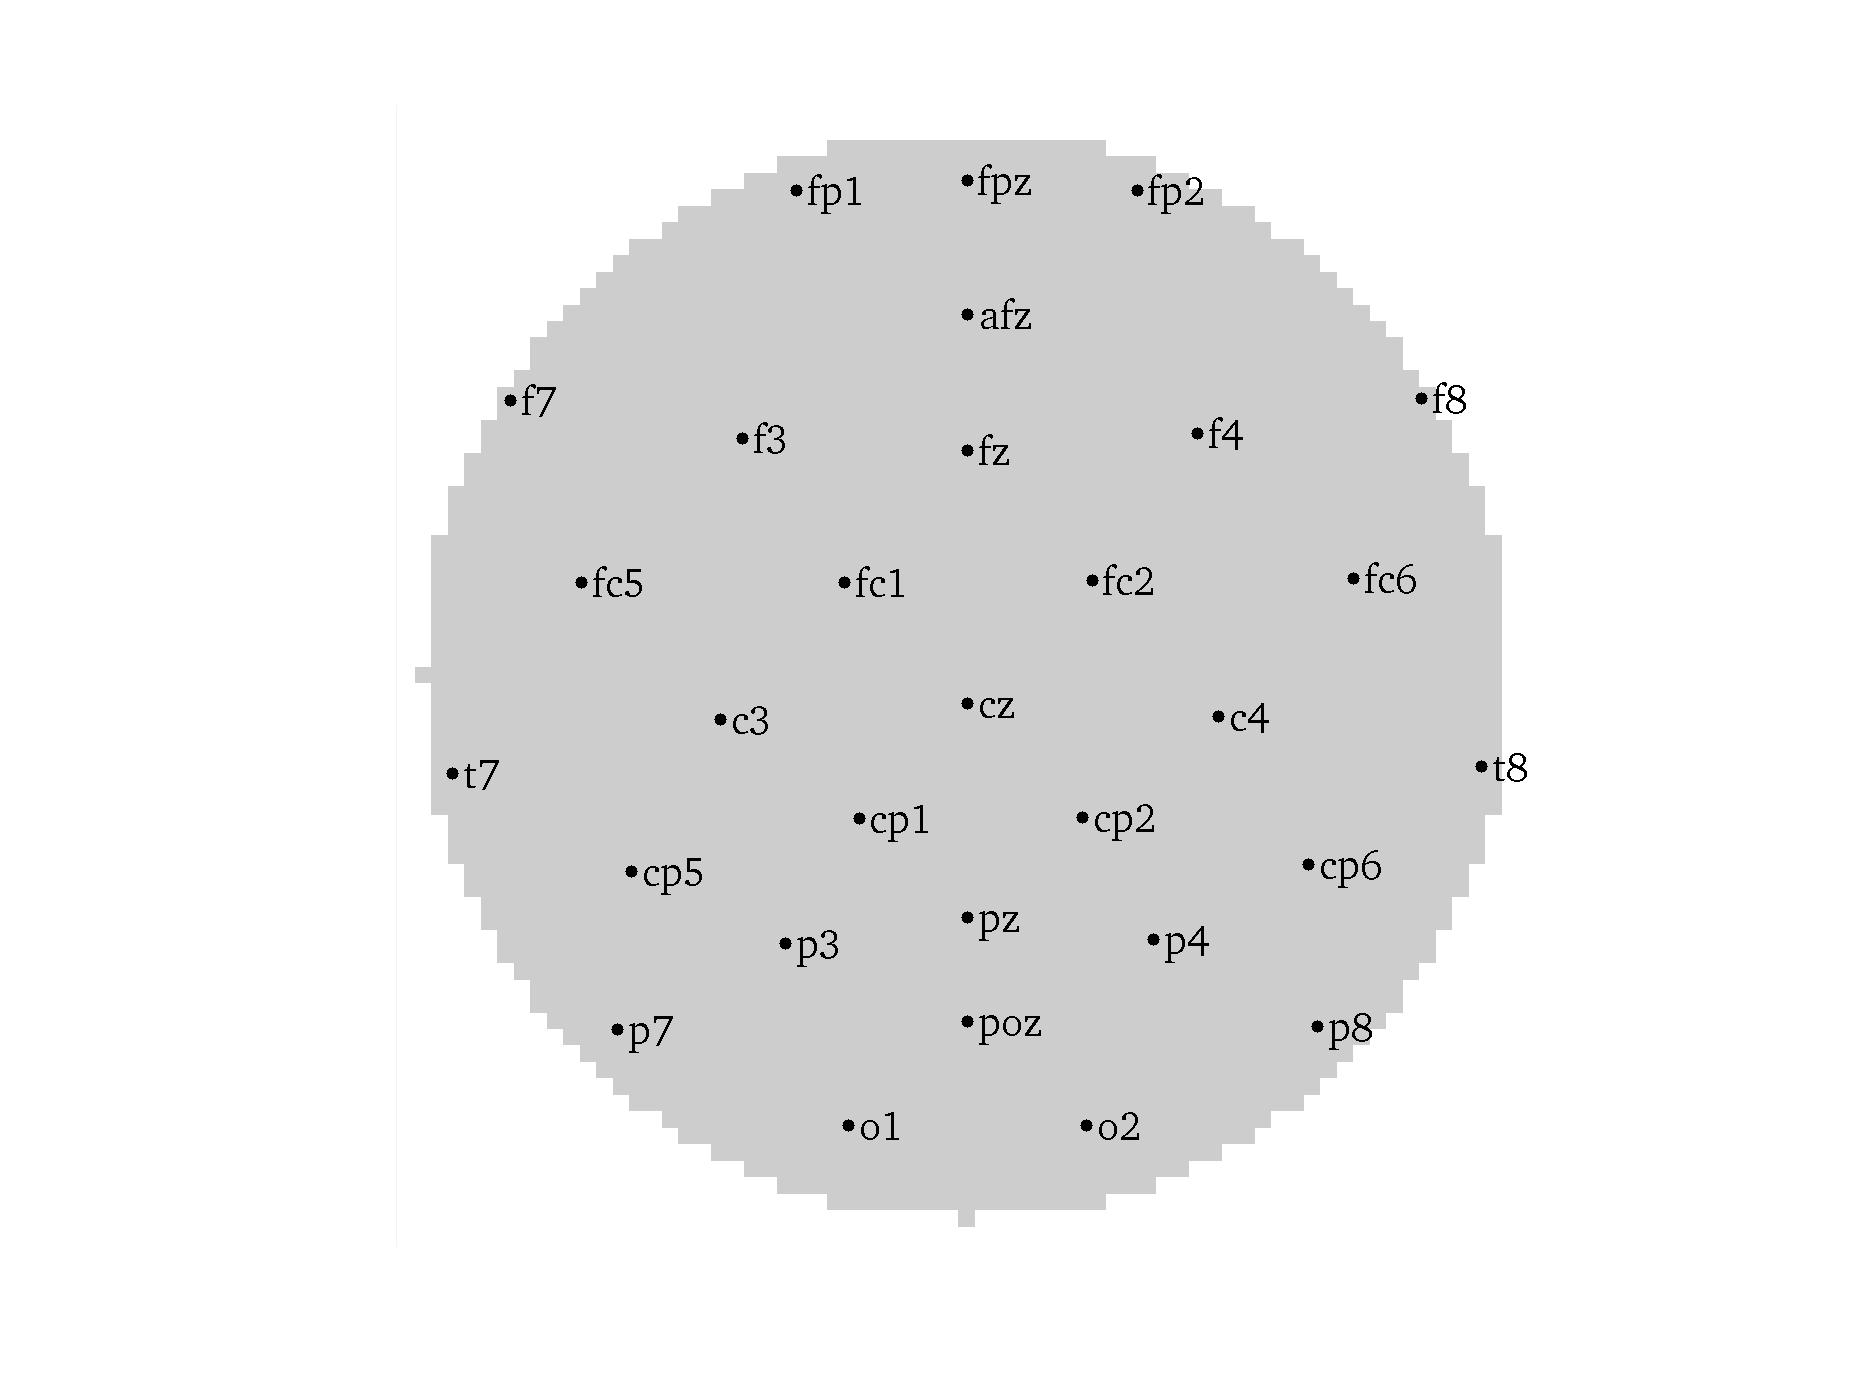

# 6. Inspección de EEG's procesados

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf.

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{u_{i}}$   donde $c$ es la cantidad total de canales y $u_{i}$ es la medición del i-ésimo canal.

El *average reference* se calcula $v_i=u_i-\bar{u}$ \\
El *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}v_{i}^2}$ (para cada tiempo *t* o muestra *n*).
Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

Para cada indice identificados del máximo de GCP se calcula cuanto vale $v_{i}$.

In [21]:
eeg.data.shape

(7681, 30)

In [105]:
def extraction_gfp(eeg, prominence,distance,height):
  u_mean = np.mean(eeg.dataT(), axis=0)  
  v_i = eeg.dataT() - u_mean
  gfp=np.sqrt(1/30*np.sum(v_i**2,axis=0)) 
  peaks, _ = find_peaks(gfp, height=height, prominence=prominence,distance=distance)
  v_i_peaks=v_i[:,peaks]
  print("Cantidad de picos de GCP:", len(peaks))
  print("El intervalo temporal entre máximos de GCP promedio es:",np.mean(np.diff(peaks))/eeg.sfrequency,'ms')
  print("El intervalo temporal entre máximos de GCP más chico es:",min(np.diff(peaks))/eeg.sfrequency,'ms')
  print("El intervalo temporal entre máximos de GCP más grande es:",max(np.diff(peaks))/eeg.sfrequency,'ms')
  return gfp, peaks, v_i_peaks

In [111]:
gfp,peaks,v_i_peaks=extraction_gfp(eeg,1,8,0)

Cantidad de picos de GCP: 588
El intervalo temporal entre máximos de GCP promedio es: 0.10204163117546848 ms
El intervalo temporal entre máximos de GCP más chico es: 0.0625 ms
El intervalo temporal entre máximos de GCP más grande es: 0.234375 ms


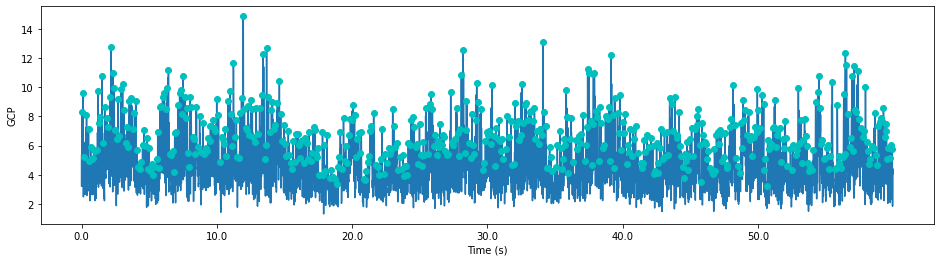

In [112]:
t = np.arange(0, eeg.data.shape[0]/eeg.sfrequency, 1/eeg.sfrequency)
plot_GPF(gfp, peaks, t)

In [113]:
data = np.transpose(v_i_peaks)
data.shape

(588, 30)

In [114]:
df = pd.DataFrame(data, columns=mont1020_30.ch_names)

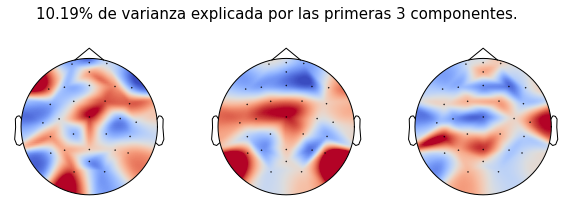

In [115]:
plot_eeg_pca(info_eeg, np.transpose(df))

In [ ]:
#KMeans(n_clusters=6, random_state=0).fit(df)